In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime

In [2]:
train = pd.read_csv('../train.csv')
oil = pd.read_csv('../oil.csv')
stores = pd.read_csv('../stores.csv')
transactions = pd.read_csv('../transactions.csv')
test = pd.read_csv('../test.csv')
holidays = pd.read_csv('../holidays_events.csv')
sampleSub = pd.read_csv('../sample_submission.csv')

# investigate train

### add missing dates

In [11]:
train.set_index('date', inplace=True)
train.head(3)

,id,store_nbr,family,sales,onpromotion
date,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.0,0
2013-01-01,1,1,BABY CARE,0.0,0
2013-01-01,2,1,BEAUTY,0.0,0


In [6]:
train.describe()

,id,store_nbr,sales,onpromotion
count,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06
mean,1.500444e+06,2.750000e+01,3.577757e+02,2.602770e+00
std,8.662819e+05,1.558579e+01,1.101998e+03,1.221888e+01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,7.502218e+05,1.400000e+01,0.000000e+00,0.000000e+00
50%,1.500444e+06,2.750000e+01,1.100000e+01,0.000000e+00
75%,2.250665e+06,4.100000e+01,1.958473e+02,0.000000e+00
max,3.000887e+06,5.400000e+01,1.247170e+05,7.410000e+02


In [26]:
time = train.date.unique()
time = pd.DataFrame(time, columns=['date'])
time['date'] = pd.to_datetime(time['date'])

In [27]:
time = time.set_index('date')
print(time.shape)
time = time.resample('1D').asfreq()
print(time.shape)

(1684, 0)
(1688, 0)


In [28]:
time = time.reset_index()

In [30]:
train['date'] = pd.to_datetime(train['date'])
train1 = pd.merge(train, time, on=['date'], how='outer')
print(train.shape, train1.shape)

(3000888, 6) (3000892, 6)


In [ ]:
# TODO: figure out if we really need that & how we interpolate

### investigate sum of all sales

- remove jan 1st from general model! -> always a big outlier -> can hardcode

In [78]:
sum = train.groupby('date')[['sales','onpromotion']].sum()

In [79]:
sum = sum.resample('1D').asfreq()

In [80]:
sum.fillna(0.01, inplace=True)

In [81]:
sum.loc[(sum.index < pd.to_datetime("2015-01-10")) & (sum.index > pd.to_datetime("2014-12-20"))]

,sales,onpromotion
date,,
2014-12-21,1.056605e+06,1579.00
2014-12-22,1.008143e+06,1582.00
2014-12-23,1.064978e+06,3365.00
2014-12-24,9.659829e+05,5828.00
2014-12-25,1.000000e-02,0.01
2014-12-26,8.720985e+05,5714.00
2014-12-27,7.405962e+05,1747.00
2014-12-28,7.163296e+05,1859.00
2014-12-29,7.739984e+05,1783.00


In [82]:
sum.loc[(sum.index < pd.to_datetime("2016-01-10")) & (sum.index > pd.to_datetime("2015-12-20"))]

,sales,onpromotion
date,,
2015-12-21,1.072887e+06,1811.00
2015-12-22,1.141862e+06,4122.00
2015-12-23,1.196146e+06,9276.00
2015-12-24,1.083680e+06,1838.00
2015-12-25,1.000000e-02,0.01
2015-12-26,9.467252e+05,1725.00
2015-12-27,8.377141e+05,2582.00
2015-12-28,7.896849e+05,1316.00
2015-12-29,8.707620e+05,3848.00


<Axes: xlabel='date'>

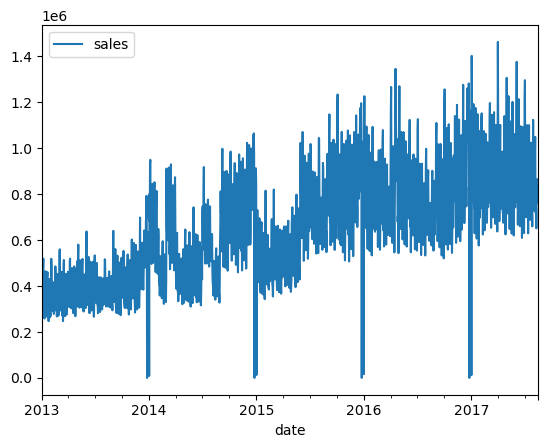

In [83]:
sum[['sales']].plot()

<Axes: xlabel='date'>

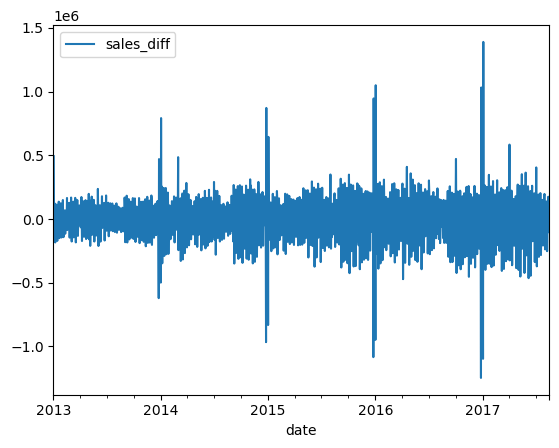

In [84]:
sum['sales_diff'] = sum.sales.diff()
sum[['sales_diff']].plot()

### stationary test
- strong weekly / biweekly correlation
- variance gets bigger over time (garch model)
- stationary with diff


TODO:
- need to check if all products are as periodic, I guess every product is different
- maybe a separate model for each store & product is the best

In [54]:
from itertools import combinations
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA as ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt

In [52]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    MA = timeseries.rolling(window = 12).mean()
    MSTD = timeseries.rolling(window = 12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(MA, color='red', label='Rolling Mean')
    std = plt.plot(MSTD, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

def tsplot(y, lags=None, name = '', figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        plt.savefig(name + '_pacf.jpg')
        fig.show()

In [67]:
sum['sales']

date
2013-01-01      2511.618999
2013-01-02    496092.417944
2013-01-03    361461.231124
2013-01-04    354459.677093
2013-01-05    477350.121229
                  ...      
2017-08-11    826373.722022
2017-08-12    792630.535079
2017-08-13    865639.677471
2017-08-14    760922.406081
2017-08-15    762661.935939
Name: sales, Length: 1684, dtype: float64

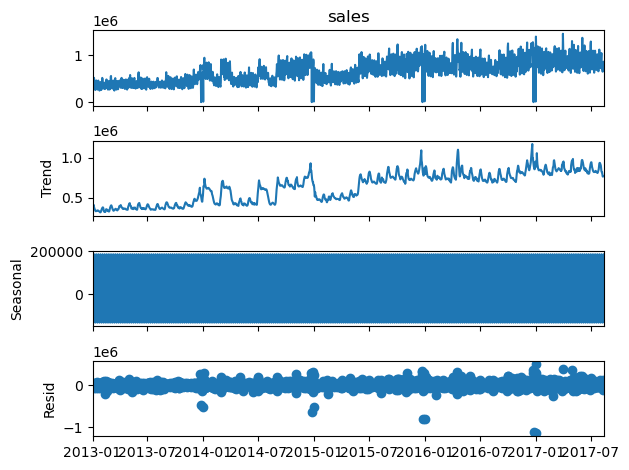

In [87]:
dec = sm.tsa.seasonal_decompose(sum['sales'], model = 'multiplicative').plot()

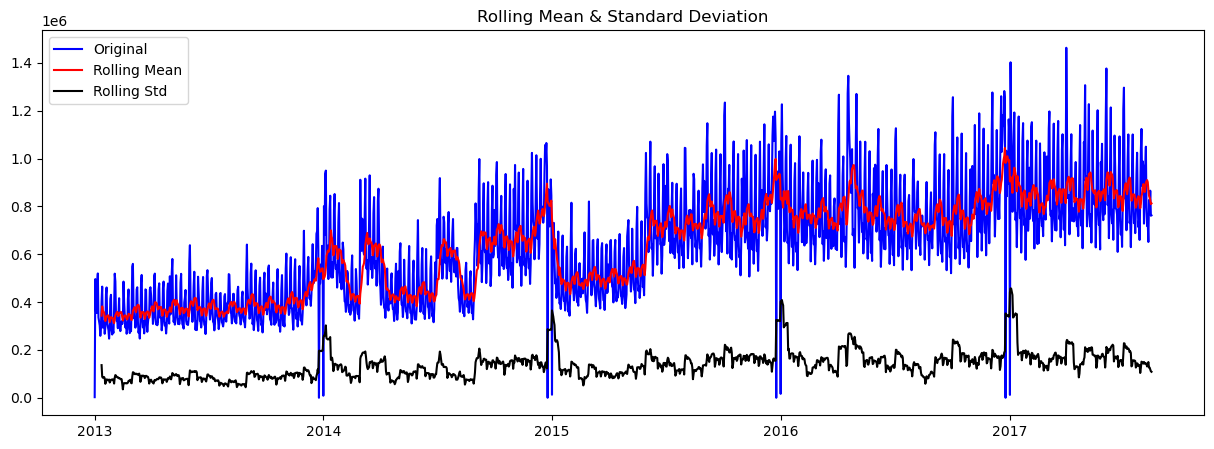

Results of Dickey-Fuller Test:
Test Statistic                   -2.571414
p-value                           0.099051
#Lags Used                       22.000000
Number of Observations Used    1665.000000
Critical Value (1%)              -3.434284
Critical Value (5%)              -2.863277
Critical Value (10%)             -2.567695
dtype: float64


In [90]:
test_stationarity(sum['sales'])

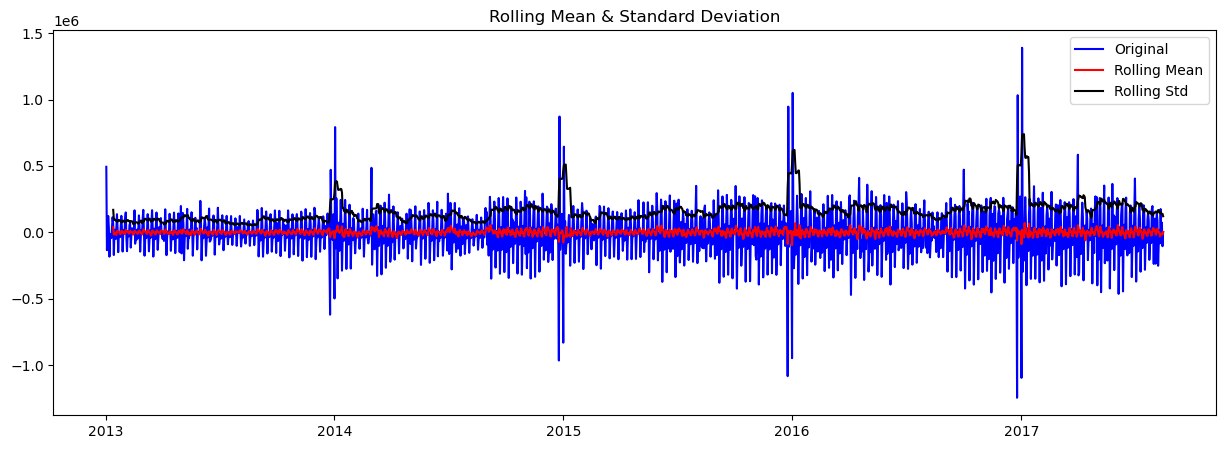

Results of Dickey-Fuller Test:
Test Statistic                -1.131158e+01
p-value                        1.235234e-20
#Lags Used                     2.500000e+01
Number of Observations Used    1.661000e+03
Critical Value (1%)           -3.434293e+00
Critical Value (5%)           -2.863282e+00
Critical Value (10%)          -2.567697e+00
dtype: float64


In [92]:
test_stationarity(sum['sales'].diff().dropna())

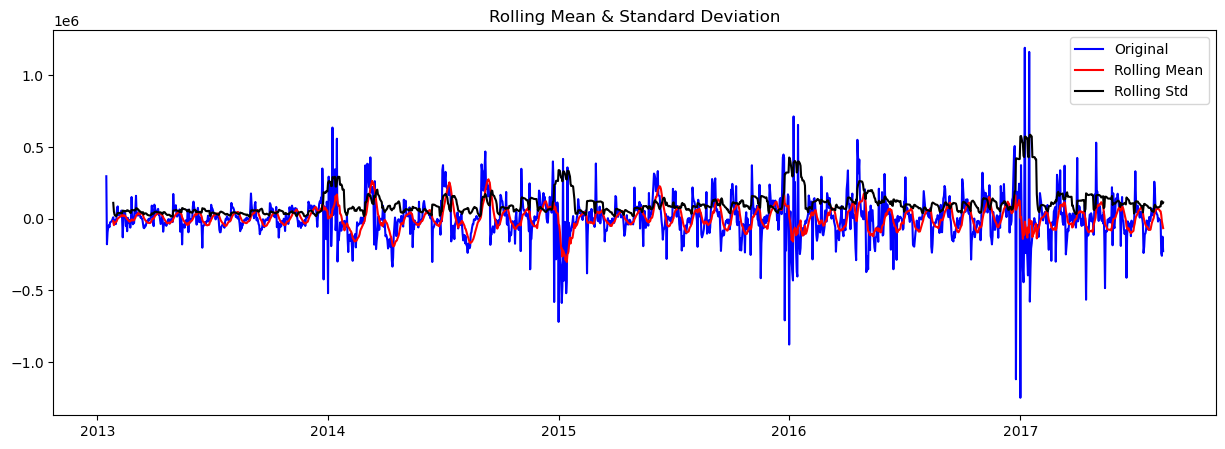

Results of Dickey-Fuller Test:
Test Statistic                -9.352384e+00
p-value                        8.229299e-16
#Lags Used                     2.200000e+01
Number of Observations Used    1.651000e+03
Critical Value (1%)           -3.434317e+00
Critical Value (5%)           -2.863292e+00
Critical Value (10%)          -2.567703e+00
dtype: float64


In [93]:
test_stationarity(sum['sales'].diff(14).dropna())

In [96]:
dataWithoutOutliers = sum.copy()
dataWithoutOutliers.reset_index(inplace=True)
mask = (dataWithoutOutliers['date'].dt.month == 12) & (dataWithoutOutliers['date'].dt.day == 25) | (dataWithoutOutliers['date'].dt.month == 1) & (dataWithoutOutliers['date'].dt.day == 1)

dataWithoutOutliers = dataWithoutOutliers[~mask]
dataWithoutOutliers.set_index('date', inplace=True)
dataWithoutOutliers = dataWithoutOutliers.resample("1D").asfreq()
dataWithoutOutliers.interpolate(inplace=True)

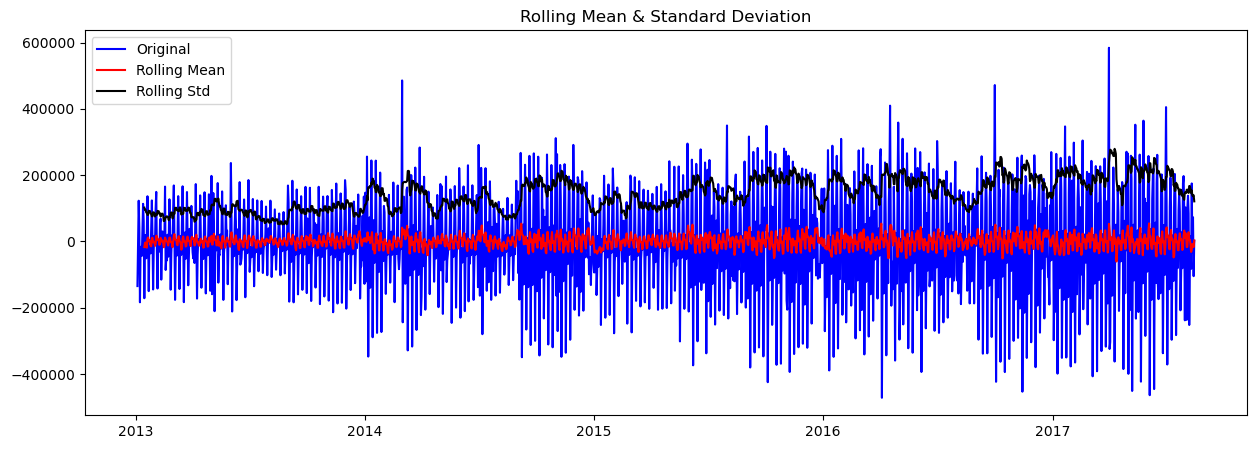

Results of Dickey-Fuller Test:
Test Statistic                -1.171126e+01
p-value                        1.487105e-21
#Lags Used                     2.500000e+01
Number of Observations Used    1.660000e+03
Critical Value (1%)           -3.434295e+00
Critical Value (5%)           -2.863283e+00
Critical Value (10%)          -2.567698e+00
dtype: float64


In [99]:
test_stationarity(dataWithoutOutliers['sales'].diff().dropna())

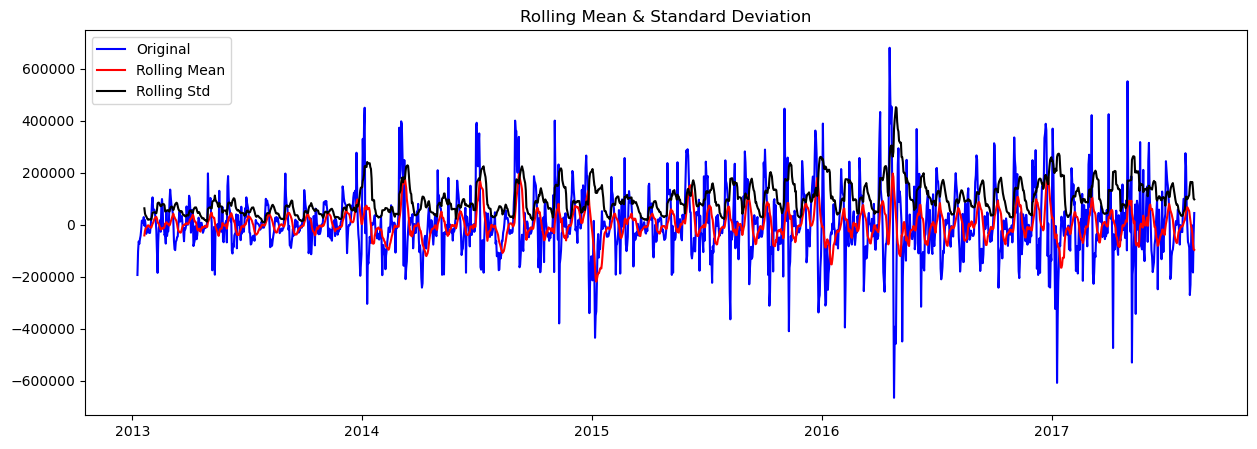

Results of Dickey-Fuller Test:
Test Statistic                -1.134011e+01
p-value                        1.059710e-20
#Lags Used                     2.300000e+01
Number of Observations Used    1.656000e+03
Critical Value (1%)           -3.434305e+00
Critical Value (5%)           -2.863287e+00
Critical Value (10%)          -2.567700e+00
dtype: float64


In [103]:
test_stationarity(dataWithoutOutliers['sales'].diff(7).dropna())

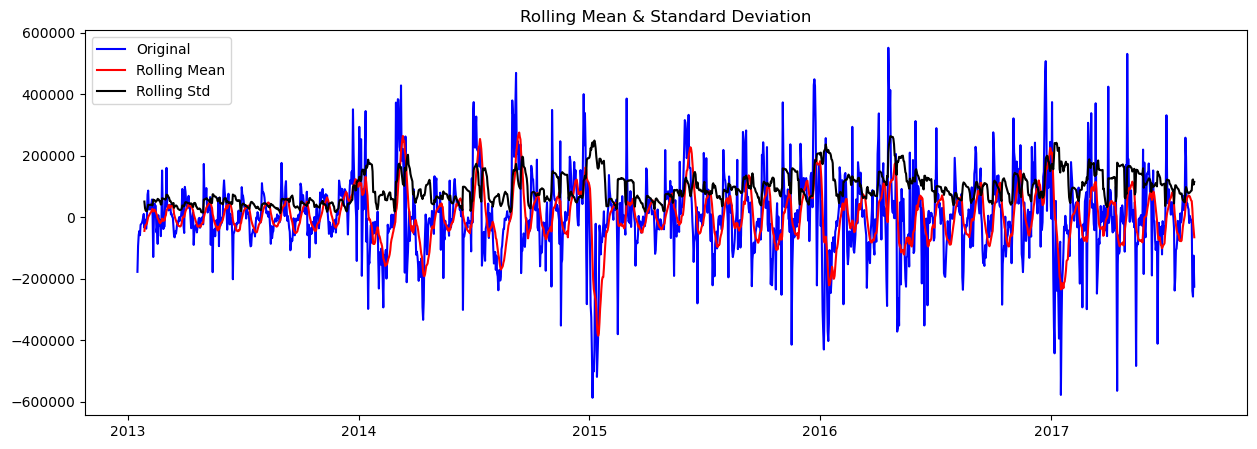

Results of Dickey-Fuller Test:
Test Statistic                -8.339165e+00
p-value                        3.210884e-13
#Lags Used                     2.400000e+01
Number of Observations Used    1.648000e+03
Critical Value (1%)           -3.434324e+00
Critical Value (5%)           -2.863295e+00
Critical Value (10%)          -2.567705e+00
dtype: float64


In [97]:
test_stationarity(dataWithoutOutliers['sales'].diff(14).dropna())

/var/folders/15/v1vyry112dv3d398dy47k8v40000gn/T/ipykernel_25883/569242055.py:41: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


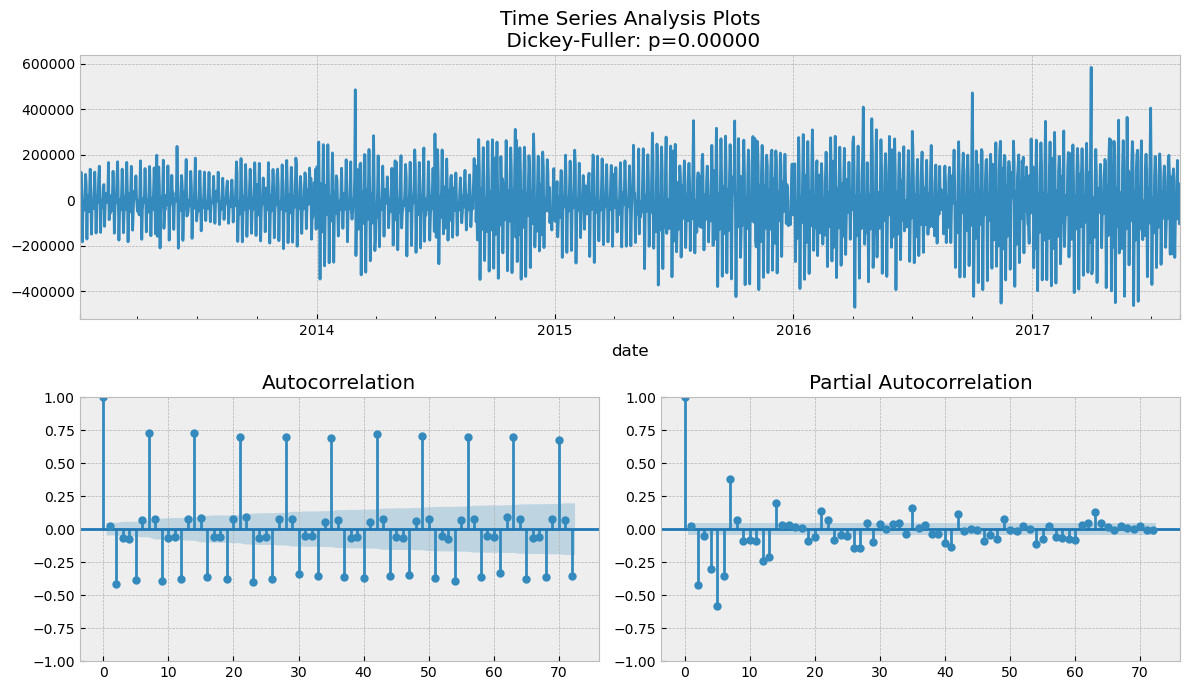

In [101]:
tsplot(dataWithoutOutliers['sales'].diff().dropna(),lags = 72)

/var/folders/15/v1vyry112dv3d398dy47k8v40000gn/T/ipykernel_25883/569242055.py:41: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


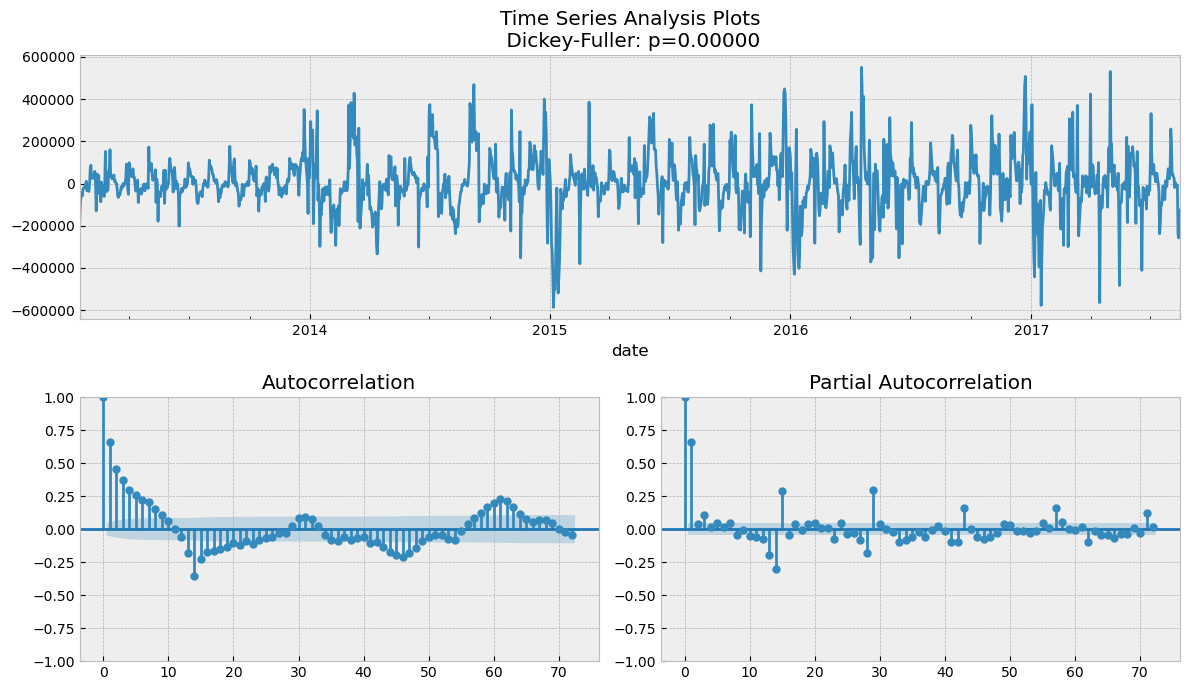

In [105]:
tsplot(dataWithoutOutliers['sales'].diff(14).dropna(),lags = 72)

### check for one store & product predictability
- different products in one store look very different over time
- same products in different stores look very different over time

Result: model for each product and each store separately!

In [110]:
train.loc[train.store_nbr == 10].family.unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

<Axes: >

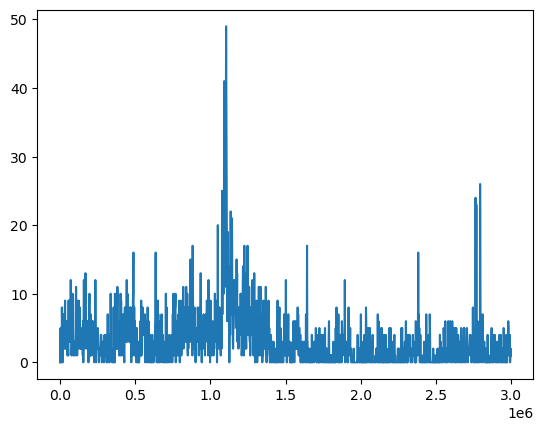

In [112]:
train.loc[(train.store_nbr == 10) & (train.family == 'LINGERIE')].sales.plot()

<Axes: >

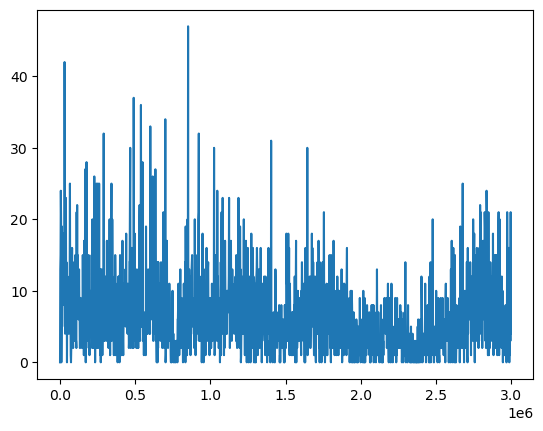

In [117]:
train.loc[(train.store_nbr == 1) & (train.family == 'LINGERIE')].sales.plot()

<Axes: >

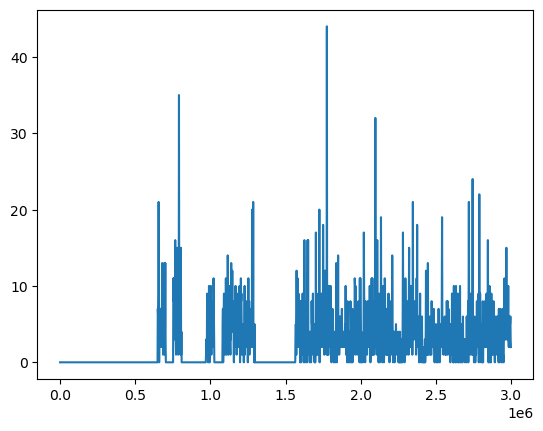

In [114]:
train.loc[(train.store_nbr == 10) & (train.family == 'CELEBRATION')].sales.plot()